In [1]:
# !pip3 install pygad
import numpy as np
from integer_rref import i4mat_rref
# from sympy import Matrix

import pygad
import matplotlib.pyplot as plt
from cytools import Polytope
from cytools.triangulation import Triangulation
from cytools.utils import find_new_affinely_independent_points

from cytools import read_polytopes, fetch_polytopes


Info: A more recent version of CYTools is available: v1.0.4 -> v1.0.11.
We recommend upgrading before continuing.
On Linux and macOS you can update CYTools by running 'cytools --update'
and on Windows you can do this by running the updater tool.



In [2]:
# p = Polytope([[ 0,  0,  0],
#    [-1, -1,  0],
#    [-1,  1,  0],
#    [ 2, -1,  0],
#    [ 0,  0, -1],
#    [ 0,  0,  1],
#    [-1,  0,  0],
#    [ 0, -1,  0],
#    [ 1, -1,  0]])

# p = Polytope([
#     [-1, 6, 2, 3],
#     [0, -1, 2, 3],
#     [0, 0, -1, 0],
#     [0, 0, 0, -1],
#     [1, 6, 2, 3]
# ])

p = Polytope([
    [-1, 4, 2, 3],
    [0, -1, 1, 2],
    [0, -1, 2, 3],
    [0, 0, -1, 0],
    [0, 0, 0, -1],
    [0, 0, 2, 3],
    [0, 2, 0, 1],
    [1, 4, 2, 3]
])



pts = p.points()[1:]


gene_size = pts.shape[0]*2

In [3]:
p

A 4-dimensional reflexive lattice polytope in ZZ^4

In [4]:
def get_indices(p, subp):
    return [np.where(np.all(v == p, axis=1))[0][0] for v in subp]

def boundary(simplices):
    dsimplices = []
    for s in simplices:
        for i in range(1, len(s)):
            dsimplices.append(
                np.append(s[:i], s[(i+1):]))

    dsimplices = np.asarray(dsimplices)
    return dsimplices

def restrict(dsimplices, subp_vertices):
    sub_simplices = np.where(np.all(np.isin(dsimplices, subp_vertices), axis=1))[0]
    sub_simplices = dsimplices[sub_simplices]

    local_sub_simplices = []
    for s in sub_simplices:
        local_s = []
        for v in s:
            local_s.append(np.where(subp_vertices == v)[0][0])
        local_sub_simplices.append(local_s)
    return np.unique(local_sub_simplices, axis=0)

def project(vertices):
    vertices_copy = np.array(vertices, copy=True)
    W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
    local_vertices = np.round(vertices@np.linalg.pinv(W))
    idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))
    
    return np.delete(local_vertices, idx, axis=1)

In [5]:
def reduce_polytope(vertices):
    vertices_copy = np.array(vertices, copy=True)
    W = np.asarray(i4mat_rref(vertices.shape[0], vertices.shape[1], vertices_copy)[0]).astype(np.float64)
    local_vertices = np.round(vertices@np.linalg.pinv(W))
    idx = np.argwhere(np.all(local_vertices[..., :] == 0, axis=0))
    
    return Polytope(np.delete(local_vertices, idx, axis=1))

In [6]:
gene_size//2

22

In [7]:

solutions = []

fibration_dimension = 3
def fitness_func(ga_instance, solution, solution_idx):
    pts_sol = solution[:gene_size//2]
    mask = (pts_sol > 0)
    vertices = pts[mask]

    error = 0
    if vertices.size == 0:
        return -2000

    error += (np.linalg.matrix_rank(vertices) - fibration_dimension)**2
    p_reduced = reduce_polytope(vertices)

    error += (1 - p_reduced.is_reflexive())**2
    error += (fibration_dimension - p_reduced.dimension())**2

    # Construct a triangulation 
    heights_sol = solution[gene_size//2:]
    heights = [-1e3] + [pt.dot(pt) + heights_sol[i] for i, pt in enumerate(pts)]

    t = p.triangulate(heights = heights)
    error += (1-t.is_star())**2 + (1-t.is_fine())**2 + (1-t.is_regular())**2

    if error == 0:
        # Restrict triangulation
        subsimplices = restrict(
            dsimplices = boundary(t.simplices()),
            subp_vertices = get_indices(
                p.points(), Polytope(vertices).points()))

        try:
            pts_reduced = p_reduced.points()
            triang_pts_reduced_indices = p_reduced._triang_pt_inds(None)
            tsub = Triangulation(
                triang_pts = pts_reduced[triang_pts_reduced_indices,:],
                simplices = subsimplices)
        except Exception as e:
            # print(e)
            # print(subsimplices)
            return -1000 - error

        error += (1-tsub.is_star())**2 + (1-tsub.is_fine())**2 + (1-tsub.is_regular())**2
    else:
        error += 1010
    if error == 0:
        solutions.append((vertices, t, tsub))
    return -error



In [8]:
# Initialize GA

ga_instance = pygad.GA(
    fitness_func=fitness_func,
    num_genes=gene_size,
    save_best_solutions=False,

    num_generations=200,
    num_parents_mating=10,
    sol_per_pop=15,

    init_range_low=-2,
    init_range_high=2,
    gene_type=float,

    parent_selection_type="rws",
    keep_parents=-1,
    # stop_criteria="reach_0",
    crossover_type="two_points",
    mutation_type="random",
    keep_elitism=10,
    mutation_percent_genes=20)

In [9]:
ga_instance.run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


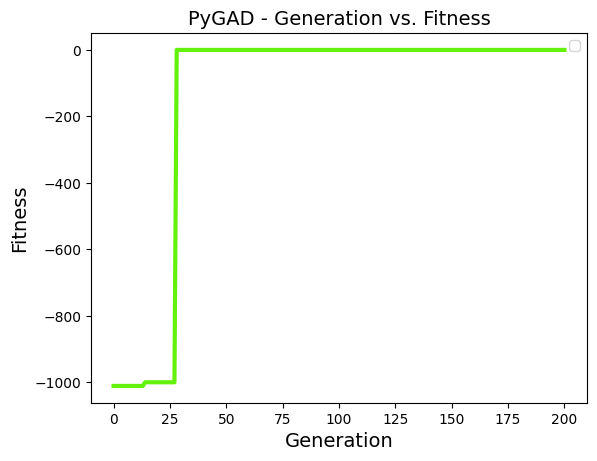

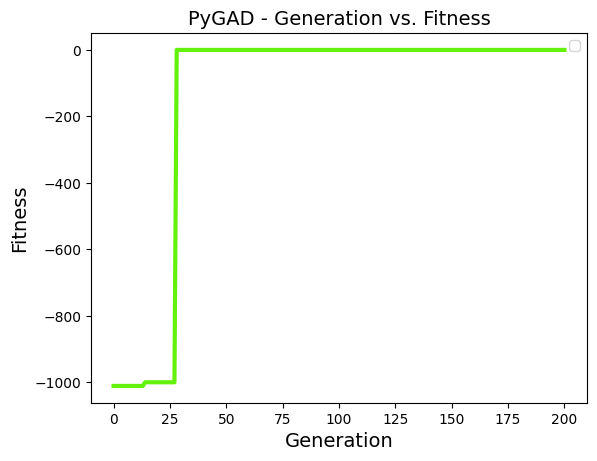

In [10]:
ga_instance.plot_fitness()

In [11]:
(vertices, t, tsub) = solutions[0]

In [12]:
solutions

[(array([[ 0,  0,  0, -1],
         [ 0, -1,  1,  2],
         [ 0,  0, -1,  0],
         [ 0, -1,  2,  3],
         [ 0,  2,  0,  1],
         [ 0,  1,  0,  0],
         [ 0,  4,  2,  3],
         [ 0,  1,  2,  3],
         [ 0,  2,  1,  1],
         [ 0,  2,  2,  3],
         [ 0,  3,  1,  2],
         [ 0,  0,  1,  1],
         [ 0,  1,  0,  1],
         [ 0,  1,  1,  2],
         [ 0,  2,  1,  2]]),
  A fine, regular, star triangulation of a 4-dimensional point configuration with 16 points in ZZ^4,
  A fine, regular, star triangulation of a 3-dimensional point configuration with 14 points in ZZ^3),
 (array([[ 0,  0,  0, -1],
         [ 0, -1,  1,  2],
         [ 0,  0, -1,  0],
         [ 0, -1,  2,  3],
         [ 0,  2,  0,  1],
         [ 0,  1,  0,  0],
         [ 0,  4,  2,  3],
         [ 0,  1,  2,  3],
         [ 0,  2,  1,  1],
         [ 0,  3,  1,  2],
         [ 0,  0,  1,  1],
         [ 0,  1,  0,  1],
         [ 0,  1,  1,  2],
         [ 0,  2,  1,  2]]),
  A fine, 

Text(0.5, 0, '$z$')

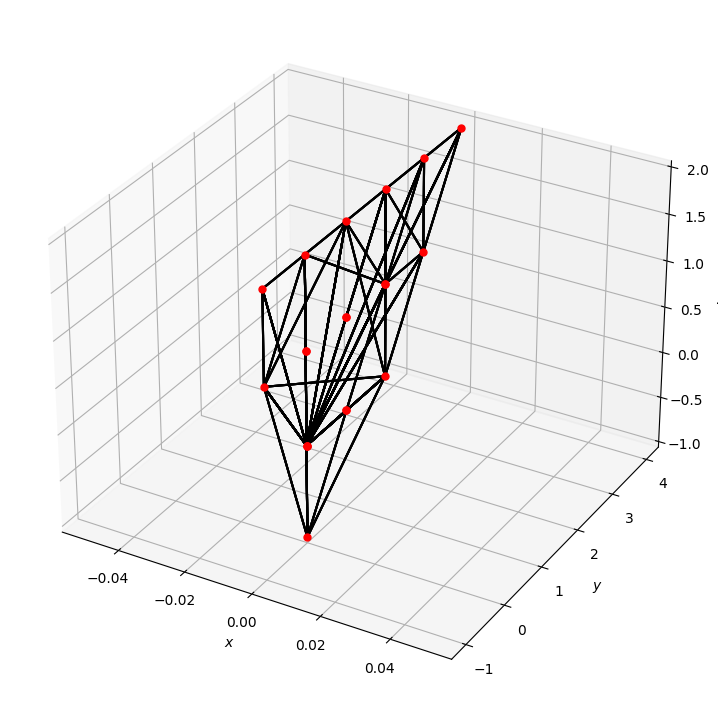

In [13]:
# Plot the facets
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')


def plot(simplices, p, params = None):
    for i, simplex in enumerate(simplices):
        for j in range(len(simplex)):
            for k in range(len(simplex)):
#                 if j == k: continue
                facet_j = lambda j: p[simplex[j % len(simplex)]]

                if params is None:
                    params = {
                        'c': 'k',
                        'linewidth': '5',
                    }

                ax.plot(
                    [facet_j(j)[0], facet_j(j+k)[0]],
                    [facet_j(j)[1], facet_j(j+k)[1]],
                    [facet_j(j)[2], facet_j(j+k)[2]], **params)
        print("")


# plot(simplices, p)

(v, t, t_restriction) = solutions[0]
v = Polytope(v).points()

# plot(t.simplices(), p.points())
# ax.plot(p.points()[:,0], p.points()[:,1], p.points()[:,2], 'bo')

plot(t_restriction.simplices(), v, params = {'c': 'k'})
ax.plot(v[:,0], v[:,1], v[:,2], 'ro', markersize=5)
# ax.plot(subp_2[:,0], subp_2[:,1], subp_2[:,2], 'ro', markersize=5)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

In [16]:
k3_subset = reduce_polytope(vertices)
print(k3_subset.points())

[[ 0  0  0]
 [ 0  0 -1]
 [-1  1  2]
 [-1  2  3]
 [ 0 -1  0]
 [ 2  0  1]
 [ 4  2  3]
 [ 0  2  3]
 [ 1  0  0]
 [ 1  2  3]
 [ 2  1  1]
 [ 2  2  3]
 [ 3  1  2]
 [ 3  2  3]
 [ 0  0  1]
 [ 0  1  1]
 [ 0  1  2]
 [ 1  0  1]
 [ 1  1  1]
 [ 1  1  2]
 [ 2  1  2]]


In [80]:
pts = k3_subset.points()
pt_inds = k3_subset._triang_pt_inds(None)

In [81]:
subsimplices = restrict(
    dsimplices = boundary(t.simplices()),
    subp_vertices = get_indices(
        p.points(), Polytope(vertices).points()))

In [82]:
Triangulation(
    triang_pts = pts[pt_inds,:],
    simplices = subsimplices)

A fine, regular, star triangulation of a 3-dimensional point configuration with 14 points in ZZ^3

In [19]:
k3_subset.chi(lattice='M')

24